In [3]:
#RNN(recurrent neural network Daily)

import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import itertools
import datetime
import warnings
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from statsmodels.tsa.seasonal import seasonal_decompose


import warnings

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [4]:
df = pd.read_excel("D://Khalid//Magang//PELNI_RevenueRegression//Revenue-Regression//revenueDaily.xlsx")
df = df.rename(columns={'tanggal': 'ds'})
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')
df = df.rename(columns={'penghasilan_muatan': 'y'}) #RENAME KOLOM REVENUE MENJADI y

# df = df.astype({'y':'int'})
# df.asfreq('d')
df = df.set_index('ds')
df = df.sort_index()
df

,y,org,kode_org,des,kode_des
ds,,,,,
2020-11-13,115483600.0,TANJUNG PRIOK,431,PULAU BATAM,256
2020-11-17,223102965.0,TANJUNG PRIOK,431,JAYAPURA,974
2020-11-17,11770200.0,TANJUNG PRIOK,431,MAKASSAR,893
2020-11-17,205426000.0,TANJUNG PRIOK,431,SORONG,971
2020-11-17,232000.0,TANJUNG PRIOK,431,SERUI,975
...,...,...,...,...,...
2023-04-04,372000.0,JAYAPURA,974,MANOKWARI,972
2023-04-05,66820000.0,AMPENAN/LEMBAR,651,WAINGAPU,685
2023-04-05,10000000.0,BIAK,973,SURABAYA,563


In [5]:
data = df.loc[(df['kode_des']==431)] #ambil data by destination doang
data = pd.DataFrame(data)
logic = {'y': 'sum'}
data = data.resample('W-SUN').apply(logic)
data

,y
ds,
2020-11-22,21891600.0
2020-11-29,82167900.0
2020-12-06,25570700.0
2020-12-13,33002000.0
2020-12-20,81230000.0
...,...
2023-03-12,589943335.0
2023-03-19,142535977.0
2023-03-26,785915116.0


In [6]:
#ELIMINASI OUTLIERS
#Deteksi pakai Interquartile Range (IQR):

n = 0
x = 1
while x != 0:   
    n+=1
    q1 = data['y'].quantile(0.25)
    q3 = data['y'].quantile(0.75)
    iqr = q3 - q1

    # identify outliers
    lower_fence = q1 - 1.5*iqr
    upper_fence = q3 + 1.5*iqr
    outliers = data.loc[(data['y'] < lower_fence) | (data['y'] > upper_fence)]
    x= len(outliers)
    if x > 0:
        print("Outliers ke-",n,": ",outliers)
    # remove outliers
    data = data.loc[(data['y'] >= lower_fence) & (data['y'] <= upper_fence)]
print("Min - Max Value :",min(data['y']),"-",max(data['y']))
data

Outliers ke- 1 :                        y
ds                     
2022-12-18  858652051.0
Min - Max Value : 0.0 - 829809500.0


,y
ds,
2020-11-22,21891600.0
2020-11-29,82167900.0
2020-12-06,25570700.0
2020-12-13,33002000.0
2020-12-20,81230000.0
...,...
2023-03-12,589943335.0
2023-03-19,142535977.0
2023-03-26,785915116.0


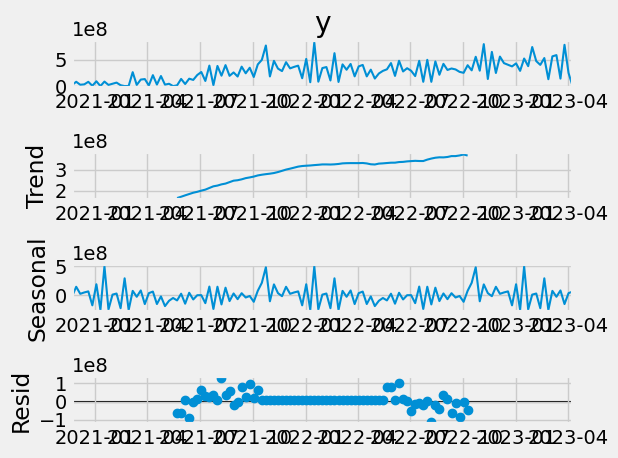

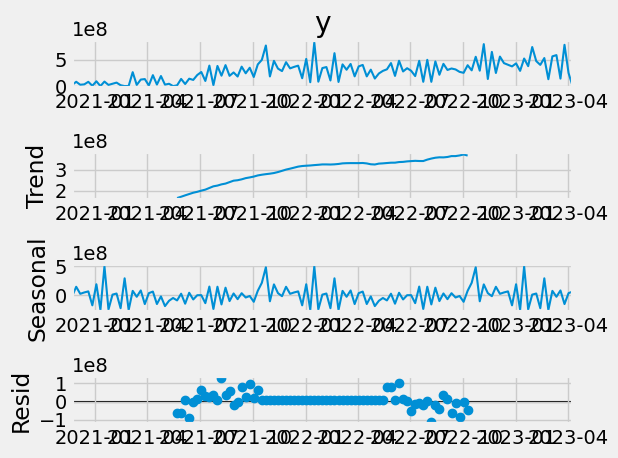

In [14]:
#INTERPOLASI
data = data.asfreq('w')
data = data.interpolate(method='linear')
data = data.fillna(0)
result = seasonal_decompose(data['y'], model = 'additive')
result.plot()

In [15]:
len(data)

125

In [16]:
steps = 28
train = data[:-steps]
test  = data[-steps:]

In [17]:
#MINMAXSCALER
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [18]:
scaled_train[:10]

array([[0.02638148],
       [0.0990202 ],
       [0.03081514],
       [0.03977057],
       [0.09788994],
       [0.00697618],
       [0.11014643],
       [0.        ],
       [0.10328744],
       [0.02638148]])

In [19]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
#define generator
n_input = 5 #Give prediction based on 5 month
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)


In [21]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.02638148 0.0990202  0.03081514 0.03977057 0.09788994]
Predict this y: 
 [[0.00697618]]


In [22]:
X.shape

(1, 5, 1)

In [23]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [25]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [27]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
85/85 [==============================] - 6s 10ms/step - loss: 0.0515
Epoch 2/50
85/85 [==============================] - 1s 11ms/step - loss: 0.0354
Epoch 3/50
85/85 [==============================] - 1s 12ms/step - loss: 0.0355
Epoch 4/50
85/85 [==============================] - 1s 10ms/step - loss: 0.0356
Epoch 5/50
85/85 [==============================] - 1s 11ms/step - loss: 0.0303
Epoch 6/50
85/85 [==============================] - 1s 12ms/step - loss: 0.0363
Epoch 7/50
85/85 [==============================] - 1s 11ms/step - loss: 0.0343
Epoch 8/50
85/85 [==============================] - 1s 11ms/step - loss: 0.0326
Epoch 9/50
85/85 [==============================] - 1s 10ms/step - loss: 0.0349
Epoch 10/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0324
Epoch 11/50
85/85 [==============================] - 1s 11ms/step - loss: 0.0313
Epoch 12/50
85/85 [==============================] - 1s 12ms/step - loss: 0.0304
Epoch 13/50
85/85 [==================

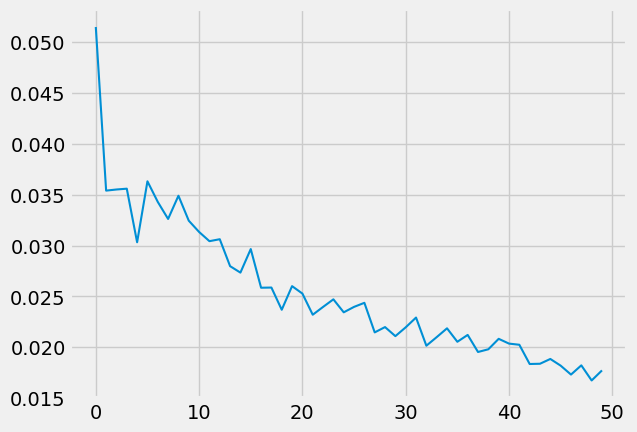

In [28]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [29]:
last_train_batch = scaled_train[-12:]

In [30]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [31]:
model.predict(last_train_batch)

1/1 [==============================] - 1s 641ms/step


array([[0.37888563]], dtype=float32)

In [32]:
scaled_test[0]

array([0.30443807])

In [33]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 61ms/step


In [34]:
test_predictions

[array([0.37888563], dtype=float32),
 array([0.39024442], dtype=float32),
 array([0.34998602], dtype=float32),
 array([0.4447952], dtype=float32),
 array([0.31271252], dtype=float32),
 array([0.47916025], dtype=float32),
 array([0.2995791], dtype=float32),
 array([0.4840948], dtype=float32),
 array([0.30985105], dtype=float32),
 array([0.45304883], dtype=float32),
 array([0.3296947], dtype=float32),
 array([0.41557252], dtype=float32),
 array([0.35228592], dtype=float32),
 array([0.4056703], dtype=float32),
 array([0.35938662], dtype=float32),
 array([0.41076016], dtype=float32),
 array([0.35181367], dtype=float32),
 array([0.424025], dtype=float32),
 array([0.34115165], dtype=float32),
 array([0.43592328], dtype=float32),
 array([0.3345676], dtype=float32),
 array([0.43666822], dtype=float32),
 array([0.33552772], dtype=float32),
 array([0.42791462], dtype=float32),
 array([0.3433385], dtype=float32),
 array([0.41868627], dtype=float32),
 array([0.3512568], dtype=float32),
 array([0.4

In [35]:
test.head()

,y
ds,
2022-10-02,252625603.0
2022-10-09,397294789.0
2022-10-16,299681740.0
2022-10-23,558172460.0
2022-10-30,293199143.0


In [36]:
true_predictions = scaler.inverse_transform(test_predictions)

In [37]:
test['Predictions'] = true_predictions

C:\Users\khali\AppData\Local\Temp\ipykernel_20768\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='ds'>

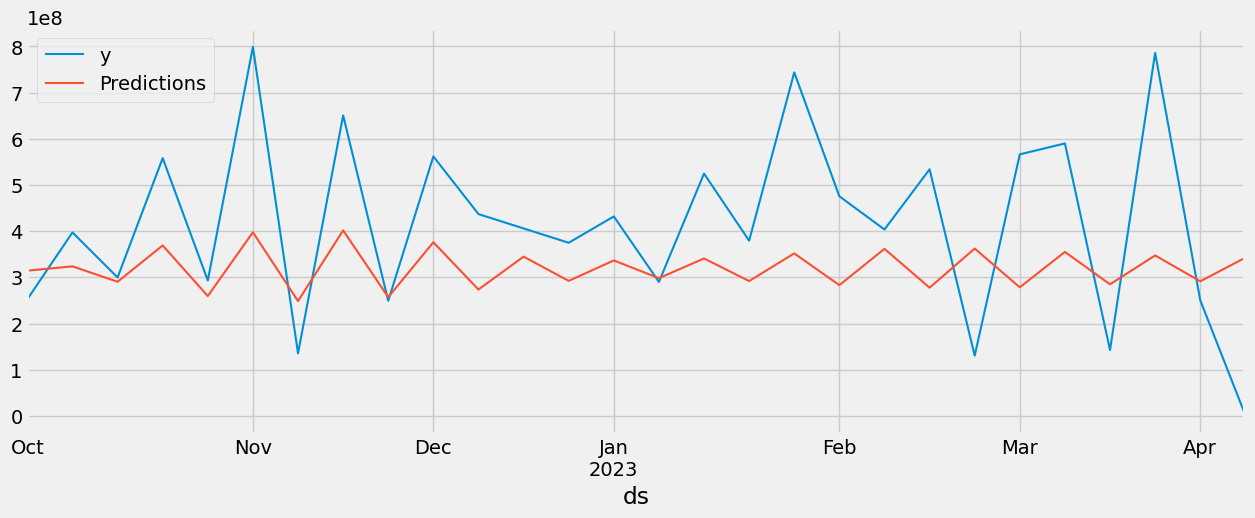

In [38]:
test.plot(figsize=(14,5))

In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['y'],test['Predictions']))
print(rmse) 
print("Mean Value of Test Dataset:", test['y'].mean())

205714782.3919273
Mean Value of Test Dataset: 416604004.25
